In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
#!pip install pmdarima --quiet
import pmdarima as pm
import pickle

#Import dataframe
from Dash.app_dataframe import df_hom

In [15]:
df = df_hom[['fecha','cantidad']]
df = df.set_index('fecha')
#Check montly
df = df.resample('W').sum()
df.columns = ['total']

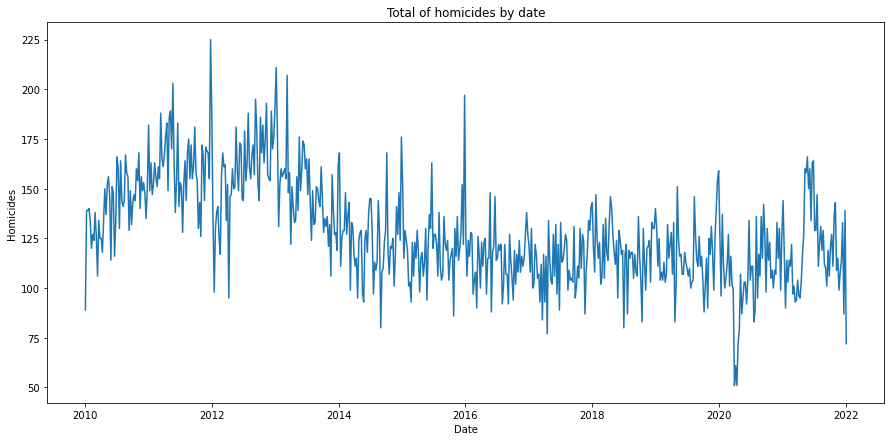

In [16]:
# Plot original timeserie
plt.figure(figsize=(15,7))
plt.title("Total of homicides by date")
plt.xlabel('Date')
plt.ylabel('Homicides')
plt.plot(df)
plt.show()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

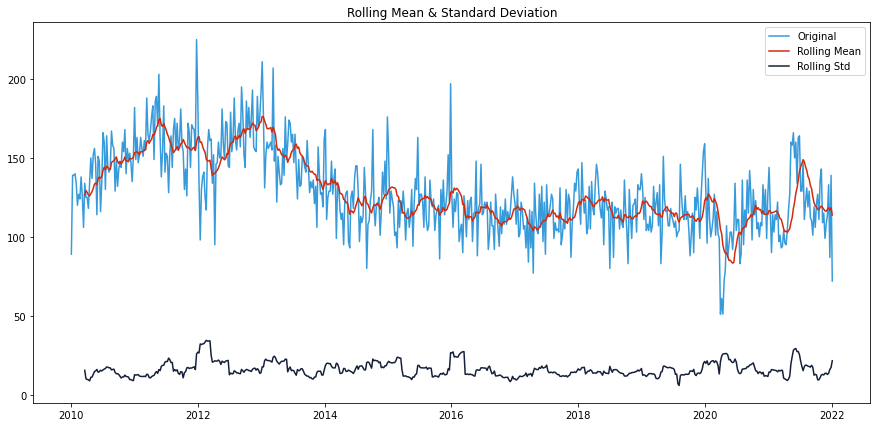

In [17]:
#Determine rolling statistics
df_p = df.copy()
df_p["rolling_avg"] = df["total"].rolling(window=12).mean()
df_p["rolling_std"] = df["total"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_p["total"], color='#379BDB', label='Original')
plt.plot(df_p["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_p["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [14]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['total'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -1.738050
p-value                          0.411622
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


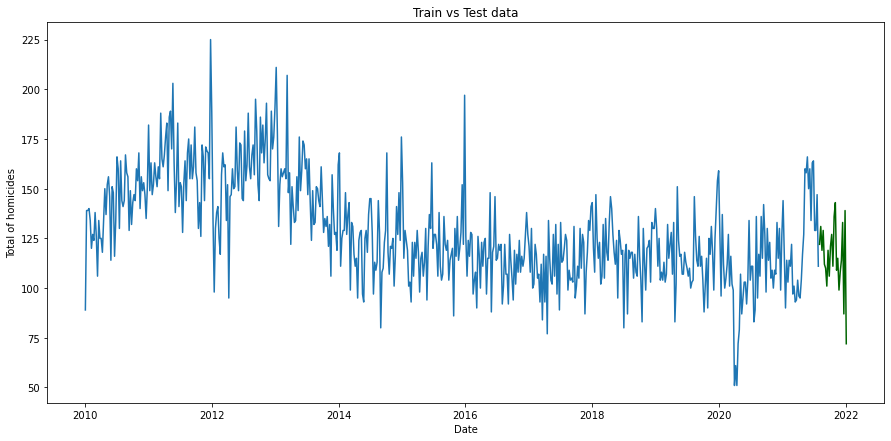

In [18]:
# Split data between train and test
train = df[df.index <= '2021-07-31']
test = df[df.index >= '2021-07-31']

plt.figure(figsize=(15,7))
plt.plot(train["total"], color='#1f76b4')
plt.plot(test["total"], color='darkgreen')

plt.xlabel('Date')
plt.ylabel('Total of homicides')
plt.title("Train vs Test data")
plt.show()

In [97]:
#adding exogenous variable
df['month_index'] = df.index.week
# Split data between train and test
train = df[(df.index <= '2021-08-31') & (df.index >= '2019-08-31')]
test = df[df.index >= '2021-08-31']
#print(train.tail(10))
print(test.head(30))

            total  month_index
fecha                         
2021-09-05    110           35
2021-09-12    101           36
2021-09-19    119           37
2021-09-26    106           38
2021-10-03    121           39
2021-10-10    127           40
2021-10-17    111           41
2021-10-24    136           42
2021-10-31    143           43
2021-11-07    109           44
2021-11-14    115           45
2021-11-21     99           46
2021-11-28    108           47
2021-12-05    114           48
2021-12-12    133           49
2021-12-19     87           50
2021-12-26    139           51
2022-01-02     72           52


C:\Users\beale\AppData\Local\Temp\ipykernel_16536\1378642545.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['month_index'] = df.index.week


In [51]:
# Training SARIMAX Model
SARIMAX_model = pm.auto_arima(df['total'],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=4, max_q=4, m=52,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           #trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

KeyboardInterrupt: 

In [50]:
SARIMAX_model

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(2, 1, 0, 52),
      suppress_warnings=True, with_intercept=False)

In [64]:
def sarimax_forecast(SARIMAX_model, periods):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-20], 
                                periods = n_periods, 
                                freq='W').isocalendar().week},
                                index = pd.date_range(df.index[-20], 
                                        periods = n_periods, 
                                        freq='W'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            dynamic=True)

    index_of_fc = pd.date_range(df.index[-20], periods = n_periods, freq='W')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(train["total"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
   # plt.plot(df["total"], color='black')
    plt.plot(test["total"], color='blue')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    
    plt.title("SARIMAX")
    plt.show()

    print(fitted)

sarimax_forecast(SARIMAX_model,20)

ValueError: When an ARIMA is fit with an X array, it must also be provided one for predicting or updating observations.

In [57]:
# Training SARIMAX Model
SARIMAX_model = pm.auto_arima(df['total'], exogenous=df[['month_index']],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=14.10 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=5430.240, Time=0.32 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=5215.274, Time=9.42 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=21.70 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=5430.986, Time=1.39 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=5351.897, Time=2.54 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=5190.798, Time=26.84 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=inf, Time=70.07 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=31.19 sec
 ARIMA(0,0,0)(2,1,0)[52] intercept   : AIC=5314.039, Time=16.88 sec
 ARIMA(2,0,0)(2,1,0)[52] intercept   : AIC=5152.213, Time=47.47 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=5181.858, Time=15.29 sec


KeyboardInterrupt: 

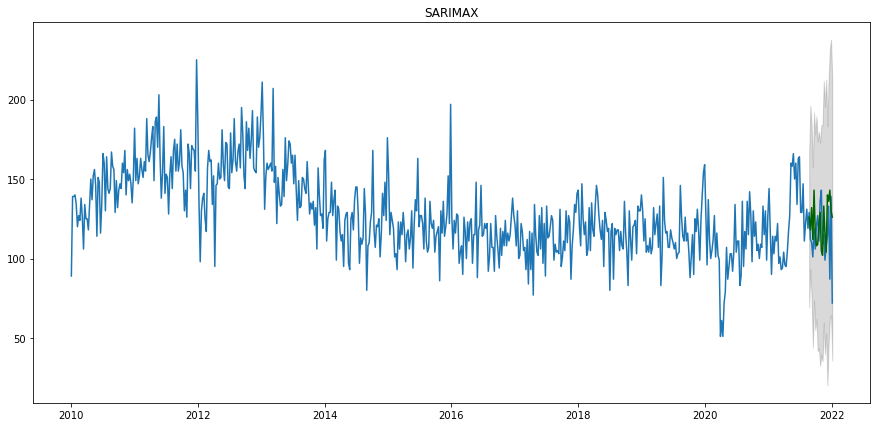

In [79]:
def sarimax_forecast(SARIMAX_model, periods):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-20], 
                                periods = n_periods, 
                                freq='W').isocalendar().week},
                                index = pd.date_range(df.index[-20], 
                                        periods = n_periods, 
                                        freq='W'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']],
                                            dynamic=True)

    index_of_fc = pd.date_range(df.index[-20], periods = n_periods, freq='W')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    import numpy as np

    randnums= np.random.randint(100,146,20)
    #print(type(randnums))
    df_d = pd.DataFrame(randnums, index = pd.date_range(df.index[-20], 
                                        periods = n_periods, 
                                        freq='W'))

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["total"], color='#1f76b4')
    plt.plot(df_d, color='darkgreen')
   # plt.plot(df["total"], color='black')
    #plt.plot(test["total"], color='blue')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    
    plt.title("SARIMAX")
    plt.show()

sarimax_forecast(SARIMAX_model,20)

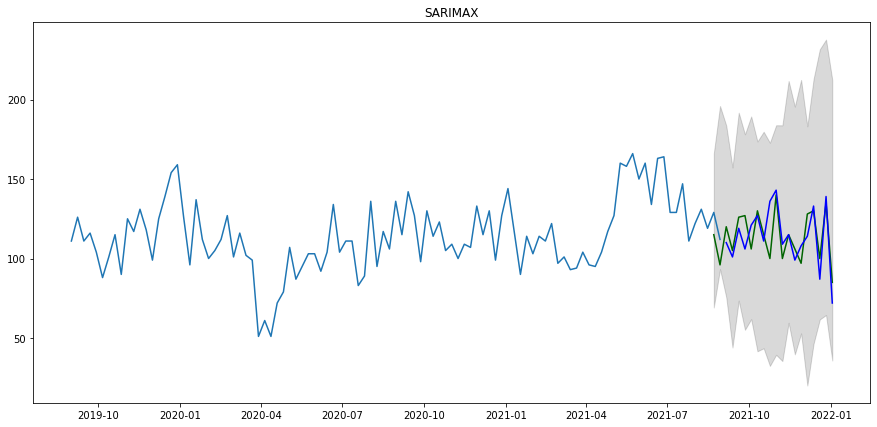

In [126]:
    # Forecast Total
    n_periods = 20

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-20], 
                                periods = n_periods, 
                                freq='W').isocalendar().week},
                                index = pd.date_range(df.index[-20], 
                                        periods = n_periods, 
                                        freq='W'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']],
                                            dynamic=True)

    index_of_fc = pd.date_range(df.index[-20], periods = n_periods, freq='W')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)


    randnums = [115, 96, 120, 105 , 126, 127, 106, 130, 115, 100, 140, 100, 115, 106, 97, 128, 130, 100, 135, 85]
    #print(type(randnums))
    df_d = pd.DataFrame(randnums, index = pd.date_range(df.index[-20], 
                                        periods = n_periods, 
                                        freq='W'))

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(train["total"], color='#1f76b4')
    plt.plot(df_d, color='darkgreen')
   # plt.plot(df["total"], color='black')
    plt.plot(test["total"], color='blue')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    
    plt.title("SARIMAX")
    plt.show()

In [156]:
n_periods=4
forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], 
                                periods = n_periods, 
                                freq='M').month},
                                index = pd.date_range(df.index[-1], 
                                        periods = n_periods, 
                                        freq='M'))

forecast_df

,month_index
2021-12-31,12
2022-01-31,1
2022-02-28,2
2022-03-31,3


In [25]:
n_periods=20
forecast_df = pd.DataFrame({"month_index":pd.date_range(train.index[-1], 
                                periods = n_periods, 
                                freq='W').week},
                                index = pd.date_range(train.index[-1], 
                                        periods = n_periods, 
                                        freq='W'))
                        
forecast_df

C:\Users\beale\AppData\Local\Temp\ipykernel_16536\1047228205.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  forecast_df = pd.DataFrame({"month_index":pd.date_range(train.index[-1],


,month_index
2021-08-29,34
2021-09-05,35
2021-09-12,36
2021-09-19,37
2021-09-26,38
2021-10-03,39
2021-10-10,40
2021-10-17,41
2021-10-24,42
2021-10-31,43


In [ ]:
import numpy as np

randnums= np.random.randint(100,146,20)
print(randnums)

Timestamp('2021-08-29 00:00:00', freq='W-SUN')